# Overview 
One of the most exciting and fun ideas in computer vision is style transfer, which is simply taking an original images (aka content image) and applying the artistic style of another image (style image) to create a new and visually interesting result (generated image).
We'll see how we can create a code able to perform this task, and we 'll also give you an intuition about the math empowring it.

##  Importing essential libraries

In [15]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 
import PIL.Image
import time

## Image processing
First step in our journey is to make some preprocessing techniques namely we must have a valid & supported input so that they can fit the neural network of interest well namely we gotta have a function for loading and another for displaying images.
The following functions are going to read the content of the image in a tensor-way so that we can use it directly through the next coming functions. 
These comming functions are availabe in the Tensorflow tutorial of style-transfer: https://www.tensorflow.org/tutorials/generative/style_transfer

In [16]:
def load_img(img_path):
    #This first step gonna make us read the file and convert it into a tensor with normalized values
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels = 3) #Make sure the input image contains exaclty 3 channels
    img = tf.image.convert_image_dtype(img, tf.float32)
    #Specifying the scaling value
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    #Resizing the input image
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    #This is going to add the batch dimension
    img = img[tf.newaxis, :] #Tensor with shape = (1, height, width, channels)
    return img

Elementary function to display an image:(Optional)

In [17]:
def imshow(image, title): 
    #Simple function to display an image, image here should be either a numpy array or tf tensor that can be handled by matplotlib
    image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.title(title)

Let's test these two functions:

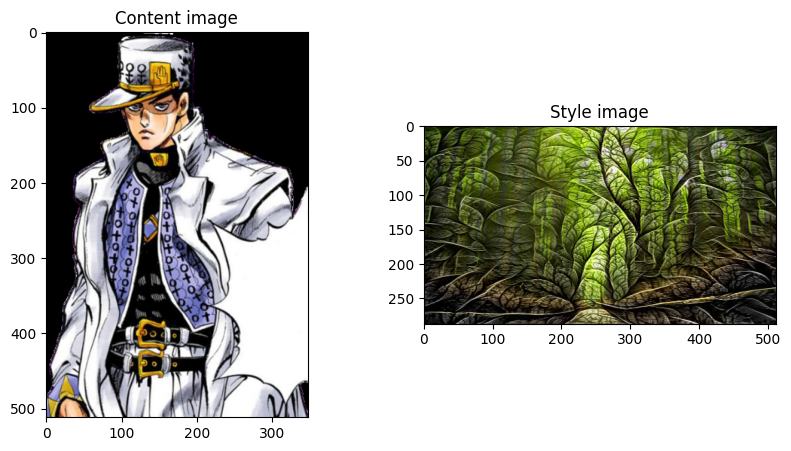

In [18]:
plt.figure(figsize=(10,5))
Cimage_path = "./Content_images/Cimage1.png"
loaded_Cimage = load_img(Cimage_path)
Simage_path = "./Style_images/Simage3.png"
loaded_Simage = load_img(Simage_path)
# Display the content image
plt.subplot(1, 2, 1)
imshow(loaded_Cimage, "Content image")
plt.subplot(1, 2, 2)
imshow(loaded_Simage, "Style image")

### Example using the tensorflow_hub
If you want to see what that means and how style will be transfered to the other image, you can try this already implemented version

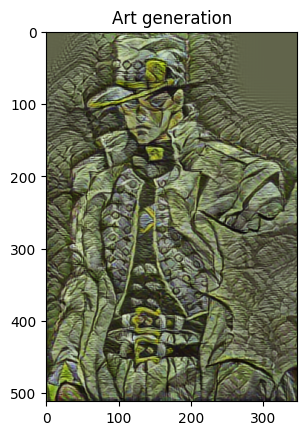

In [19]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(loaded_Cimage), tf.constant(loaded_Simage))[0]
imshow(stylized_image, "Art generation")

Let's create a function that will enhance the appearance of images.

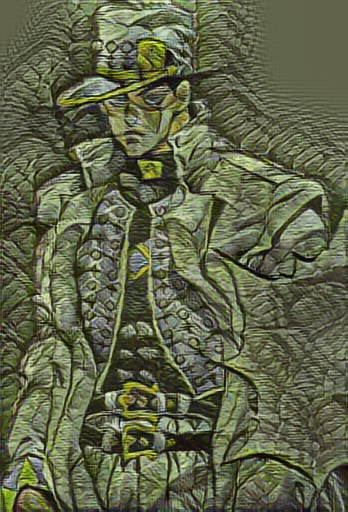

In [20]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    image = np.array(tensor, dtype = np.uint8)
    if np.ndim(image) > 3: 
        #Batch of images case
        assert image.shape[0] == 1 #As shown above: tensors contain 1 image example 
        image = image[0]
    return PIL.Image.fromarray(image)

tensor_to_image(stylized_image)

# Neural Style Transfer
The previous part is responsible to introduce you to this known technique in computer vision. In this section we' ll through multiple steps build our style transfer model and so we 'll be hard coding the theory behind it ourselves, we' ll also use the power of linear algebra to define new concepts such as the style matrix.
Since it's computationaly demanding building andt raining a deep neural network, with the technique we' ll see now things are going to be really straight-forward.

## Transfer learning 
In the field of computer vision, transfer learning is commun useful technique aims to use a pretrained model and use it for your own task. Here's an example that illustrates the process:

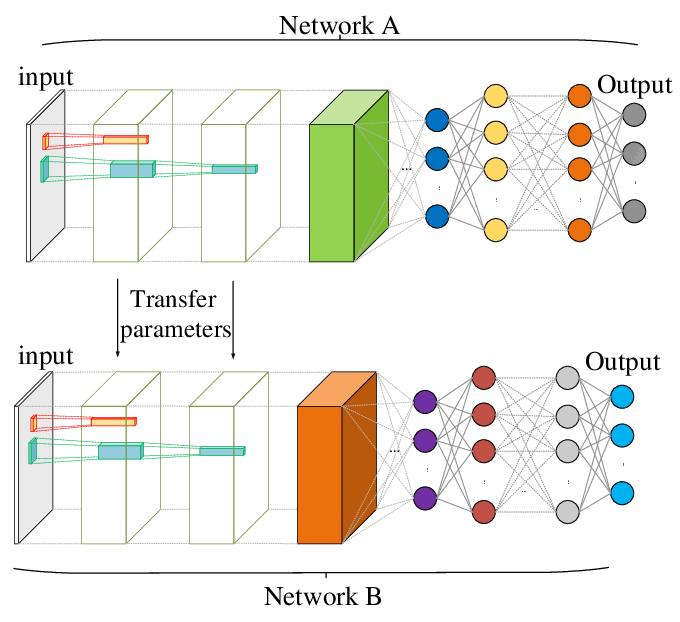


It might be complex to understand but keep in mind that those deep and fully connected layers are responsible to full fill the task itself, so that are the layers we have to freeze in order to transfer the knowledge of another task or problem to complete your own task. For our case we're going to use VGG-19, since it has 19 layers and has been trained on a large dataset of images so its shallow layers have already learned basic features, and its deep layers have learned complex high level features and luckly that what we exactly need. 

## Model building
### Step 1: Load the VGG19 model

In [21]:
#This loads and freezes the vgg19 model excluding the last layers (fully connected layers at the end of the model)
vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
vgg19_model.trainable = False 

### Step 2: Setting the content & style layers
The meaning of this is among all the layers of the VGG19 model choose the convinient layers to put on our transfer_model.

In [22]:
for layer in vgg19_model.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


#### Content layers
We' ll later why, but in neural style transfer, the choice of content and style layers is crucial for achieving the desired balance between content preservation and style transfer.

In [23]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

### Step 3: Build the model 